# 🤖 Clasificación de Dígitos con TensorFlow y Keras (MNIST)

Este cuaderno es una guía progresiva para construir y entrenar tu primera **Red Neuronal (NN)** utilizando TensorFlow y la API Keras. Clasificaremos dígitos escritos a mano (0 a 9) usando el famoso dataset **MNIST**.



----------

## 📚 1. Introducción y Preparación

### 1.1. ¿Qué es este proyecto?

Vamos a crear un modelo de **aprendizaje automático** (Machine Learning) que pueda _ver_ una imagen de un dígito (como el que dibujarías) y decirnos con alta precisión qué número es.

El **dataset MNIST** contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba, todas de $28 \times 28$ píxeles.



### 1.2. Importar Librerías Esenciales

Ejecuta la siguiente celda para cargar las herramientas necesarias.

In [11]:
# Importaciones
import tensorflow as tf
import tensorflow_datasets as tfds # Para cargar el dataset MNIST
import matplotlib.pyplot as plt    # Para visualizar imágenes y gráficos
import numpy as np
import math
import logging

# Configuración básica (ocultar mensajes de error de TFDS)
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print("TensorFlow versión:", tf.__version__)

TensorFlow versión: 2.19.0


## 💾 2. Carga y Exploración de Datos

### 2.1. Cargar el Dataset MNIST

Utilizamos `tensorflow_datasets` para descargar y cargar los datos automáticamente.

In [12]:
print("Cargando el dataset MNIST...")

# as_supervised=True: Separa automáticamente las imágenes (características) y las etiquetas (clases).
# with_info=True: Devuelve metadatos importantes sobre el dataset.
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)

# Separamos el dataset en conjuntos de entrenamiento y prueba
train_dataset, test_dataset = dataset['train'], dataset['test']

# Definimos los nombres de las clases (las 10 salidas posibles)
class_names = [
    'Cero', 'Uno', 'Dos', 'Tres', 'Cuatro', 'Cinco', 'Seis',
    'Siete', 'Ocho', 'Nueve'
]

# Obtenemos el número de ejemplos (para cálculos posteriores)
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

print(f"Total de ejemplos de entrenamiento: {num_train_examples}")
print(f"Total de ejemplos de prueba: {num_test_examples}")

Cargando el dataset MNIST...
Total de ejemplos de entrenamiento: 60000
Total de ejemplos de prueba: 10000


Esta celda de código se encarga de la  **carga y preparación inicial del dataset MNIST**  utilizando TensorFlow Datasets.

Aquí tienes un desglose de lo que hace:

1.  **`print("Cargando el dataset MNIST...")`**: Simplemente muestra un mensaje informativo en la consola indicando que el proceso de carga ha comenzado.
    
2.  **`dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)`**:
    
    -   Esta es la línea principal para cargar el dataset.
    -   `tfds.load('mnist')`  le dice a TensorFlow Datasets que cargue el conjunto de datos MNIST.
    -   `as_supervised=True`: Esta opción es muy útil porque hace que  `tfds.load`  devuelva el dataset en un formato de  `(features, label)`, es decir, cada elemento del dataset será una tupla donde el primer elemento es la imagen (las características) y el segundo es la etiqueta (el dígito que representa la imagen). Esto es ideal para tareas de clasificación.
    -   `with_info=True`: Además de devolver el dataset en sí, esta opción también devuelve  `metadata`, que contiene información valiosa sobre el dataset, como el número de ejemplos, nombres de las clases, etc.
3.  **`train_dataset, test_dataset = dataset['train'], dataset['test']`**: Una vez que el dataset principal ha sido cargado, esta línea lo divide en dos subconjuntos: uno para  **entrenamiento (`train_dataset`)**  y otro para  **prueba (`test_dataset`)**. TensorFlow Datasets organiza automáticamente estos conjuntos de datos de esta manera.
    
4.  **`class_names = [...]`**: Define una lista de cadenas de texto que representan los nombres de las clases o categorías. En este caso, son los nombres de los dígitos del cero al nueve. Esto es útil para interpretar las predicciones del modelo y para visualizaciones.
    
5.  **`num_train_examples = metadata.splits['train'].num_examples`**  y  **`num_test_examples = metadata.splits['test'].num_examples`**:
    
    -   Estas líneas extraen el número total de imágenes en los conjuntos de entrenamiento y prueba, respectivamente, de la  `metadata`  que obtuvimos al cargar el dataset. Esta información es crucial para configurar el entrenamiento de la red neuronal.
6.  **`print(...)`**: Finalmente, se imprimen los totales de ejemplos de entrenamiento y prueba para verificar que los datos se han cargado correctamente.

### 2.2. Preprocesamiento: Normalización

Las imágenes están en escala de grises, donde cada píxel tiene un valor entre **0** (negro) y **255** (blanco).

**Concepto Clave: Normalización** Es crucial para las redes neuronales convertir estos valores al rango **0.0 a 1.0**. Esto ayuda a que el modelo converja (aprenda) más rápido y de manera más estable.

In [13]:
# Función para normalizar los datos
def normalize(images, labels):
    # Convertimos los datos a float32 (números decimales)
    images = tf.cast(images, tf.float32)
    # Dividimos por 255.0 para normalizar (0-255 -> 0.0-1.0)
    images /= 255.0
    return images, labels

# Aplicamos la función 'normalize' a ambos datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

> Esta celda de código se encarga de la  **normalización de los datos**,
> un paso crucial en el preprocesamiento de imágenes para redes
> neuronales.
>
> Aquí te explico cada parte:
>
> 1.  **`def normalize(images, labels):`**: Define una función llamada  `normalize`  que toma dos argumentos:  `images`  (las imágenes del
> dataset) y  `labels`  (las etiquetas o números correspondientes a esas
> imágenes).
>     
> 2.  **`images = tf.cast(images, tf.float32)`**: Las imágenes originales (del dataset MNIST) tienen valores de píxeles que van de 0
> a 255, y su tipo de dato suele ser  `tf.uint8`  (entero sin signo de 8
> bits). Esta línea convierte esos valores a números de punto flotante
> (`tf.float32`). Esto es necesario porque las operaciones de división
> que siguen requieren números decimales.
>     
> 3.  **`images /= 255.0`**: Esta es la parte central de la normalización. Divide cada valor de píxel en la imagen por 255.0. Dado
> que los píxeles originalmente van de 0 a 255, al dividirlos por 255.0,
> los valores resultantes estarán en el rango de  **0.0 a 1.0**. Esta
> escala es muy beneficiosa para las redes neuronales, ya que ayuda a
> que el proceso de entrenamiento sea más estable y rápido.
>     
> 4.  **`return images, labels`**: La función devuelve las imágenes ya normalizadas y las etiquetas sin modificar.
>     
> 5.  **`train_dataset = train_dataset.map(normalize)`  y  `test_dataset = test_dataset.map(normalize)`**: Estas líneas aplican la función  `normalize`  a cada elemento (cada par imagen-etiqueta) en el
> `train_dataset`  (conjunto de entrenamiento) y el  `test_dataset`
> (conjunto de prueba). El método  `.map()`  es una forma eficiente en
> TensorFlow de aplicar una transformación a todos los elementos de un
> dataset.

### 2.3. Visualizar un Ejemplo Normalizado

Veamos cómo se ve una de las imágenes de entrenamiento.

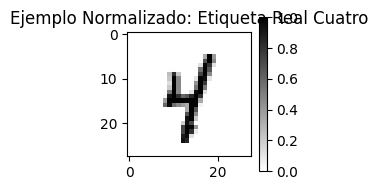

In [14]:
# Tomamos una muestra para visualizar.
for image, label in train_dataset.take(1):
    break
image = image.numpy()

plt.figure(figsize=(2,2))
# El [...,0] es para seleccionar el único canal de color (escala de grises)
plt.imshow(image[...,0], cmap=plt.cm.binary)
plt.title(f"Ejemplo Normalizado: Etiqueta Real {class_names[label.numpy()]}")
plt.colorbar()
plt.show()
#

Esta celda de código se encarga de  **visualizar una imagen de ejemplo del dataset de entrenamiento después de haber sido normalizada**. Permite verificar cómo se ven los datos que el modelo va a "aprender". Aquí te explico cada línea:

1.  **`for image, label in train_dataset.take(1): break`**:
    
    -   `train_dataset.take(1)`: Toma un único par de (imagen, etiqueta) del  `train_dataset`. Es una forma eficiente de obtener solo un elemento de un dataset de TensorFlow sin iterar por completo.
    -   `for ...: break`: Este bucle se utiliza para asignar el primer (y único) elemento tomado a las variables  `image`  y  `label`  y luego se interrumpe inmediatamente.
2.  **`image = image.numpy()`**:
    
    -   Las imágenes obtenidas del  `tf.data.Dataset`  son tensores de TensorFlow.  `image.numpy()`  las convierte a un arreglo de NumPy, que es el formato que  `matplotlib`  espera para graficar.
3.  **`plt.figure(figsize=(2,2))`**:
    
    -   Crea una nueva figura para el gráfico con un tamaño de 2x2 pulgadas, lo cual es adecuado para mostrar una imagen pequeña como las de MNIST.
4.  **`plt.imshow(image[...,0], cmap=plt.cm.binary)`**:
    
    -   `plt.imshow()`: Es la función de  `matplotlib`  para mostrar imágenes.
    -   `image[...,0]`: Las imágenes de MNIST tienen una forma  `(28, 28, 1)`, donde el  `1`  al final indica que tienen un solo canal de color (escala de grises).  `[...,0]`  selecciona ese único canal, resultando en una forma  `(28, 28)`  que  `imshow`  puede interpretar como una imagen en escala de grises.
    -   `cmap=plt.cm.binary`: Establece el mapa de color a  `binary`, lo que significa que los valores bajos se mostrarán en negro y los valores altos en blanco, típico para las imágenes de dígitos de MNIST.
5.  **`plt.title(f"Ejemplo Normalizado: Etiqueta Real {class_names[label.numpy()]}")`**:
    
    -   Establece el título del gráfico. Utiliza una f-string para incluir el texto "Ejemplo Normalizado: Etiqueta Real" y el nombre de la clase real.
    -   `class_names[label.numpy()]`:  `label`  es un tensor que contiene el número del dígito (ej.  `5`).  `label.numpy()`  lo convierte a un entero de Python, y luego se usa como índice para obtener el nombre legible de la clase (ej. "Cinco") de la lista  `class_names`  que definimos previamente.
6.  **`plt.colorbar()`**:
    
    -   Añade una barra de color al lado de la imagen, mostrando la escala de valores de píxeles (que ahora van de 0.0 a 1.0 después de la normalización).
7.  **`plt.show()`**:
    
    -   Muestra el gráfico generado. Sin esta línea, en muchos entornos (como scripts Python), el gráfico no aparecería.
___
Aunque usar un  `for`  loop con  `break`  para extraer un solo elemento pueda parecer un poco inusual o redundante si vienes de trabajar con listas o arrays de NumPy, es de hecho una forma  **muy común e idiomática**  de hacerlo cuando se trata de objetos  `tf.data.Dataset`  en TensorFlow, y sí,  **es lógico en este contexto**.

Aquí te explico por qué:

1.  **`tf.data.Dataset`  es un iterador**: A diferencia de una lista o un array, un  `tf.data.Dataset`  no carga todos sus elementos en memoria de una vez. Está diseñado para ser eficiente con grandes volúmenes de datos y para ser  _iterable_. Esto significa que para acceder a sus elementos, necesitas  _iterar_  sobre él.
    
2.  **`take(1)`  limita la iteración**: El método  `.take(1)`  transforma tu  `Dataset`  original en un nuevo  `Dataset`  que solo producirá el primer elemento y luego se detendrá. Así, te aseguras de que la iteración no procese el dataset completo.
    
3.  **`for ... break`  consume el primer elemento**: El  `for`  loop se usa para iniciar la iteración, y  `break`  se asegura de que tan pronto como obtengas el primer elemento (`image, label`), el loop se detenga inmediatamente. Por lo tanto, no hay una iteración innecesaria sobre el resto de un  `Dataset`  que ya ha sido limitado a un solo elemento por  `take(1)`.
    

**¿Hay alternativas?**

Sí, otra forma común y a menudo más concisa de obtener el primer elemento de un  `tf.data.Dataset`  es usando  `next(iter(...))`. Por ejemplo:

```
image, label = next(iter(train_dataset.take(1)))

```

Ambas formas son válidas y cumplen el mismo propósito. La clave es entender que  `tf.data.Dataset`  está optimizado para flujos de datos, y los elementos se acceden iterando sobre ellos, no directamente por índice como en otras estructuras de datos.

## 🧠 3. Definición y Compilación del Modelo

### 3.1. Estructura del Modelo Keras

Usaremos un modelo **Secuencial**, que simplemente apila capas en orden.


![][image2]

[image2]: <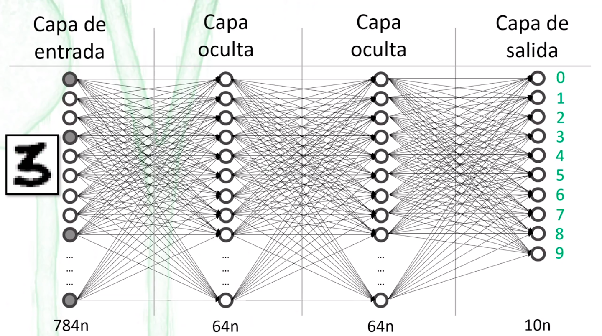>

In [15]:
print("\nDefiniendo la estructura de la Red Neuronal (Keras Sequential)...")

model = tf.keras.Sequential([
	# 1. Capa de Aplanamiento (Flatten):
	# Convierte la matriz de entrada (28x28) en un vector plano (784).
	# Es el primer paso para alimentar las capas Dense.
  tf.keras.Input(shape=(28, 28, 1)),
	tf.keras.layers.Flatten(),

	# 2. Capa Oculta (Dense):
	# Tiene 64 neuronas.
	# Activación ReLU: Introduce no-linealidad, permitiendo aprender relaciones complejas.
	tf.keras.layers.Dense(64, activation=tf.nn.relu),

	# 3. Segunda Capa Oculta (Dense):
	tf.keras.layers.Dense(64, activation=tf.nn.relu),

	# 4. Capa de Salida (Dense):
	# 10 neuronas (una para cada clase 0-9).
	# Activación Softmax: Convierte las salidas en PROBABILIDADES que suman 1.
	# La neurona con mayor probabilidad será la predicción final.
	tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


Definiendo la estructura de la Red Neuronal (Keras Sequential)...


Esta celda de código define la arquitectura de tu  **Red Neuronal**  utilizando la API  **Keras de TensorFlow**. Se construye un modelo  **`Sequential`**, que es el tipo más sencillo de modelo en Keras, donde las capas se apilan una tras otra de forma lineal. Vamos a desglosar cada parte:

1.  **`print("\nDefiniendo la estructura de la Red Neuronal (Keras Sequential)...")`**:
    
    -   Simplemente imprime un mensaje informativo en la consola.
2.  **`model = tf.keras.Sequential([...])`**:
    
    -   Esto crea una instancia de un modelo secuencial de Keras. Las capas que se definen dentro de la lista  `[...]`  se añadirán a este modelo en el orden especificado.
3.  **`tf.keras.Input(shape=(28, 28, 1))`**:
    
    -   Aunque  `tf.keras.Sequential`  a menudo infiere la forma de entrada, es una buena práctica definir explícitamente la capa de entrada con  `tf.keras.Input`. Esto especifica que cada imagen de entrada tendrá una forma de  `(28, 28, 1)`, lo que significa 28 píxeles de alto, 28 píxeles de ancho y 1 canal de color (para imágenes en escala de grises).
4.  **`tf.keras.layers.Flatten()`**:
    
    -   Esta es la capa de  **aplanamiento**. Las imágenes de entrada son matrices bidimensionales (28x28). Las capas  `Dense`  (totalmente conectadas) esperan una entrada unidimensional (un vector).  `Flatten`  toma la entrada  `(28, 28, 1)`  y la convierte en un vector plano de  `28 * 28 * 1 = 784`  píxeles. Es como desenrollar la imagen en una sola fila de números.

     ![][image1]

[image1]: <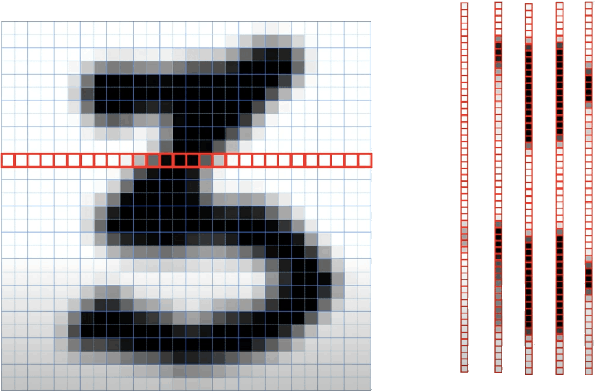>
5.  **`tf.keras.layers.Dense(64, activation=tf.nn.relu)`  (Primera Capa Oculta)**:
    
    -   Esta es una capa  **Densa**  (o totalmente conectada). Cada neurona de esta capa está conectada a todas las neuronas de la capa anterior (en este caso, a los 784 píxeles aplanados).
    -   **`64`**: Indica que esta capa tiene 64 neuronas.
    -   **`activation=tf.nn.relu`**:  `relu`  (Rectified Linear Unit) es la función de activación utilizada. Introduce  **no-linealidad**  en el modelo, lo cual es crucial para que la red pueda aprender patrones complejos. Sin funciones de activación no lineales, una red neuronal con múltiples capas densas se comportaría como una sola capa lineal.
6.  **`tf.keras.layers.Dense(64, activation=tf.nn.relu)`  (Segunda Capa Oculta)**:
    
    -   Otra capa Densa con 64 neuronas y función de activación ReLU. Esta capa toma la salida de la primera capa oculta como su entrada, permitiendo que el modelo aprenda representaciones aún más abstractas de los datos.
7.  **`tf.keras.layers.Dense(10, activation=tf.nn.softmax)`  (Capa de Salida)**:
    
    -   Esta es también una capa Densa, pero es la capa final, la de  **salida**.
    -   **`10`**: Hay 10 neuronas en esta capa, una para cada posible dígito (0 a 9) que el modelo debe clasificar.
    -   **`activation=tf.nn.softmax`**: La función de activación  `softmax`  es ideal para problemas de clasificación multiclase. Convierte las salidas numéricas de la capa en una distribución de  **probabilidades**  que suman 1. La neurona con la probabilidad más alta será la predicción de la red (por ejemplo, si la neurona del 'tres' tiene la probabilidad más alta, el modelo predice que la imagen es un 'tres').

En resumen, este código construye una red neuronal simple con una capa de entrada, dos capas ocultas y una capa de salida, diseñada para clasificar imágenes de dígitos.


# Función de activación
**Una función de activación permite que una red neuronal piense de forma no lineal**, y sin ella la red no podría aprender tareas reales.

Una **función de activación** en una red neuronal es una **operación matemática** que decide **si una neurona “se activa” o no**, y **cómo** se transmite la información a la siguiente capa.

En otras palabras:

# ✅ **Una función de activación introduce no linealidad en la red.**

Sin funciones de activación, una red neuronal sería solo una combinación de sumas y multiplicaciones → una **recta**, incapaz de aprender patrones complejos.

----------

# 🔍 ¿Por qué son importantes?

Imagina que una red neuronal intenta aprender cosas complejas como:

-   reconocer un rostro
    
-   detectar si un email es spam
    
-   clasificar animales
    
-   traducir idiomas
    

Estas tareas **no son lineales**, así que la red necesita algo más que líneas rectas.  
Ahí entran las funciones de activación.

----------

# 🧠 ¿Qué hace exactamente una función de activación?

1.  **Recibe** la suma ponderada de entradas  
    (por ejemplo: z=w1x1+w2x2+bz = w_1x_1 + w_2x_2 + bz=w1​x1​+w2​x2​+b)
    
2.  **Transforma** ese valor con una función (ReLU, Sigmoid, etc.)
    
3.  **Devuelve** un valor que se pasa a la siguiente capa
    

----------

# ✨ Intuición sencilla

Es como un **interruptor inteligente**:

-   Si la señal es baja → reduce o bloquea la salida
    
-   Si la señal es alta → la potencia o deja pasar
    
-   Y lo hace de forma **no lineal** para permitir que la red aprenda patrones complejos
    

----------

# 📌 Ejemplo visual mental

### Sin activación (lineal)

Entrada → sumasumasuma → salida  
👉 solo puede aprender líneas rectas

### Con activación (no lineal)

Entrada → sumasumasuma → **f(z)f(z)f(z)** → salida  
👉 puede aprender curvas, bordes, formas, categorías, lenguaje…

##
---
##

**Imagina que una red neuronal es como un equipo de filtros inteligentes** que mira una imagen de un número escrito a mano y trata de adivinar cuál es (0–9).



## 🔹 ¿Qué hacen las _capas ocultas_ con ReLU?

Las capas ocultas son como los **analistas internos** de la red. No ven el resultado final, pero procesan la imagen paso a paso.

La función de activación **ReLU** (Rectified Linear Unit) es muy simple:

👉 **Si el valor es positivo, lo deja pasar; si es negativo, lo pone en cero.**

Esto ayuda a la red a:

-   Aprender más rápido
    
-   Evitar que se “atasque”
    
-   Detectar patrones útiles (líneas, bordes, curvas, etc.)
    

Piensa en ReLU como un **filtro que solo deja pasar lo importante**.

----------

## 🔹 ¿Qué hace la _capa de salida_ con Softmax?

La capa de salida es quien decide finalmente **qué número vio**.

Softmax toma todos los valores que la red calculó al final y los convierte en **probabilidades**.  
Así, te da algo como:

-   0 → 0.01
    
-   1 → 0.05
    
-   2 → 0.90
    
-   … etc.
    

Softmax siempre hace que:

-   Todas las probabilidades sumen 1
    
-   La clase con mayor número sea la predicción final
    

Es como decir:  
“Según lo que analicé, estoy **90% seguro** de que este número es un 2”.

## 🔹 ¿Qué es la función _sigmoid_?

La **sigmoid** toma cualquier número (positivo o negativo) y lo convierte en un valor entre **0 y 1**.

Su forma es una curva “S”.

👉 Fórmula (solo si te interesa):

$\sigma(x) = \frac{1}{1 + e^{-x}}$

----------

## 🔹 ¿Para qué sirve?

La sigmoid es útil cuando quieres que la salida se interprete como una **probabilidad**, porque:

-   Nunca baja de **0**
    
-   Nunca sube de **1**
    

Por ejemplo, en un modelo que responde _“¿sí o no?”_, como detectar si una imagen contiene un gato, la sigmoid da valores como:

-   0.87 → “87% seguro de que sí hay un gato”
    
-   0.12 → “12% seguro”
    

----------

## 🔹 Entonces, ¿por qué ahora casi todo usa ReLU en lugar de sigmoid?

Porque la sigmoid tiene dos problemas:

1.  **Se satura:** cuando la entrada es muy grande o muy pequeña, la sigmoid deja de cambiar casi por completo → la red deja de aprender.
    
2.  **Aprende más lento** que ReLU en capas profundas.
    

Por eso hoy en día:

-   En **capas ocultas** → ReLU
    
-   En **salidas binarias (sí/no)** → Sigmoid
    
-   En **salidas con varias clases** (como dígitos 0–9) → Softmax
| Función     | Qué hace                                | Salida típica            | Para qué se usa                |
| ----------- | --------------------------------------- | ------------------------ | ------------------------------ |
| **Sigmoid** | Aplasta a 0–1                           | Probabilidad             | Clasificación binaria          |
| **ReLU**    | Deja pasar solo positivos               | 0 o x                    | Capas ocultas, redes profundas |
| **Softmax** | Convierte en probabilidades que suman 1 | Vector de probabilidades | Clasificación multiclase       |

![][image3]

[image3]: <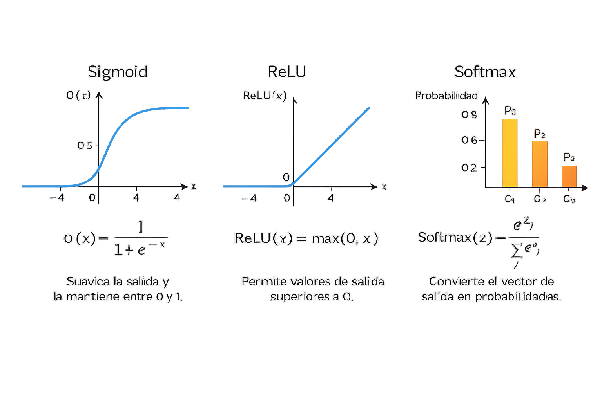>


### 3.2. Compilación: Configuración del Aprendizaje

Antes de entrenar, debemos configurar el modelo con un **optimizador**, una **función de pérdida** y métricas.

In [16]:
# Compilación: Indicamos cómo debe aprender el modelo.
model.compile(
	# Optimizador: 'adam' es un algoritmo muy eficiente para ajustar los pesos del modelo.
	optimizer='adam',

	# Función de Pérdida (Loss Function):
	# Mide "qué tan mal" están las predicciones. El objetivo del entrenamiento es MINIMIZAR este valor.
	# 'sparse_categorical_crossentropy' se usa para clasificación multiclase con etiquetas enteras.
	loss='sparse_categorical_crossentropy',

	# Métrica: Lo que queremos MAXIMIZAR, en este caso, la precisión.
	metrics=['accuracy']
)

Este código configura cómo tu modelo de red neuronal aprenderá y será evaluado durante el entrenamiento. Se utilizan tres componentes principales:

1.  **`optimizer='adam'`**: El optimizador 'Adam' es como el 'cerebro' que ajusta los pesos de la red para que aprenda eficientemente. Es muy popular por su buen rendimiento.
2.  **`loss='sparse_categorical_crossentropy'`**: La función de pérdida mide qué tan bien (o mal) el modelo predice los dígitos. 'Sparse categorical crossentropy' es ideal para este problema de clasificación donde las etiquetas son números enteros (0, 1, 2, etc.). El objetivo del entrenamiento es minimizar este valor.
3.  **`metrics=['accuracy']`**: La métrica 'accuracy' simplemente nos dice el porcentaje de predicciones correctas que hace el modelo. Queremos que este valor sea lo más alto posible.

La compilación (`model.compile`) es el paso previo que configura cómo el modelo va a aprender. En este paso, le dices a Keras qué  **optimizador**  usar (como 'adam') y qué  **función de pérdida**  (como 'sparse_categorical_crossentropy') utilizar para medir los errores.

La  **propagación hacia atrás (backpropagation)**  es el algoritmo  _interno_  que el optimizador usa durante el entrenamiento para ajustar los pesos del modelo. Es decir, una vez que el modelo hace una predicción, la función de pérdida calcula el error, y  **backpropagation**  utiliza ese error para determinar cómo cambiar cada peso en la red para reducir el error en la siguiente iteración.

Así que, mientras que la compilación  _establece_  los mecanismos de aprendizaje, backpropagation es el  _proceso real_  de ajuste de pesos que ocurre durante la fase de entrenamiento (cuando llamas a  `model.fit`).
Por lo tanto el optimizador Adam (y otros optimizadores como SGD, RMSprop, etc.) es el algoritmo que se encarga de realizar la **backpropagation** durante el entrenamiento de la red neuronal. Su trabajo es usar los gradientes de la función de pérdida para ajustar los pesos del modelo de manera eficiente y así aprender de los datos

En el contexto de una red neuronal, un  **peso**  (o  `weight`) es precisamente eso: un valor numérico que determina  **cuánto influye una entrada o característica específica**  en la activación de una neurona en la siguiente capa, y, en última instancia, en el valor de salida.

Piensa en ello así:

-   **Entradas/Características**: En nuestro caso, serían los valores de los píxeles de la imagen del dígito.
-   **Pesos**: Son como multiplicadores. Si un píxel en particular (una característica) tiene un peso alto asociado a la neurona que representa el '3', significa que ese píxel es muy importante para decidir si la imagen es un '3'.
-   **Sesgos (Bias)**: También existen los sesgos, que son como umbrales que ajustan la facilidad con la que una neurona se activa, independientemente de las entradas.
En la ecuación de una recta  `y = mx + b`:

-   `m`  sería el  **peso**  (la pendiente, cuánto influye  `x`).
-   `b`  sería el  **sesgo (bias)**  (el término independiente, dónde corta la recta el eje  `y`).

En una neurona de una red neuronal, el  **sesgo (bias)**  funciona de manera muy similar:

1.  **Es un valor adicional**  que se suma al resultado de la suma ponderada de las entradas (entradas * pesos).
2.  Permite que la función de activación de la neurona se  **desplace hacia arriba o hacia abajo**.

**¿Por qué es importante?**

Imagina que una neurona tiene la tarea de "activarse" si la suma de sus entradas ponderadas supera un cierto umbral. El sesgo le da a la neurona la flexibilidad de ajustar ese umbral de activación. Sin el sesgo, la neurona siempre pasaría por el origen (como una recta  `y = mx`), lo que limitaría enormemente su capacidad para aprender y modelar relaciones complejas en los datos.

En resumen, el sesgo le da a la red neuronal una  **mayor flexibilidad para ajustarse a los datos**  y modelar patrones que no necesariamente "pasan por el origen" de las características. Es una pieza clave para que el modelo pueda aprender incluso cuando las entradas son bajas o para evitar que se active con entradas irrelevantes.

Durante el entrenamiento, el optimizador (Adam) ajusta estos pesos y sesgos para que el modelo aprenda a asignar la importancia correcta a cada píxel y, así, haga predicciones precisas.

## 🏃 4. Entrenamiento del Modelo

### 4.1. Configuración de Lotes (Batching)

El modelo no procesa 60,000 imágenes a la vez, sino en grupos (lotes) pequeños.

In [17]:
# BATCHSIZE: El tamaño del lote de imágenes que el modelo procesa a la vez.
BATCHSIZE = 32

# .repeat(): Permite iterar sobre el dataset múltiples veces (para las 5 épocas).
# .shuffle(): Mezcla los datos al inicio de cada repetición.
# .batch(BATCHSIZE): Agrupa los datos.
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCHSIZE)
test_dataset = test_dataset.batch(BATCHSIZE)

# Número de pasos que hay que dar para recorrer todos los ejemplos en cada época
steps_per_epoch = math.ceil(num_train_examples / BATCHSIZE)

Esta celda de código es crucial para preparar tus datos para el entrenamiento del modelo, organizándolos en 'lotes' (batches) para un procesamiento más eficiente. Aquí te explico cada parte:

1.  **`BATCHSIZE = 32`**:
    
    -   Define el tamaño de cada lote. En lugar de alimentar las 60,000 imágenes de entrenamiento al modelo una por una, o todas a la vez (lo cual consumiría mucha memoria y ralentizaría el entrenamiento), las agrupamos en lotes de 32 imágenes. El modelo procesará 32 imágenes, ajustará sus pesos, y luego pasará a las siguientes 32.
2.  **`train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCHSIZE)`**:
    
    -   **`.repeat()`**: Le dice al dataset que se repita indefinidamente. Esto es útil porque, durante el entrenamiento, normalmente queremos pasar por el dataset varias veces (lo que se llama 'épocas'). Si no usamos  `repeat()`, el dataset se agotaría después de una sola pasada.
    -   **`.shuffle(num_train_examples)`**: Mezcla aleatoriamente las imágenes del conjunto de entrenamiento.  `num_train_examples`  (que es 60,000) se usa como tamaño del buffer de mezclado, lo que asegura que las imágenes se mezclen bien. Esto es fundamental para evitar que el modelo aprenda el orden de los datos en lugar de los patrones reales.
    -   **`.batch(BATCHSIZE)`**: Agrupa las imágenes mezcladas en lotes del tamaño especificado por  `BATCHSIZE`  (32 en este caso).
3.  **`test_dataset = test_dataset.batch(BATCHSIZE)`**:
    
    -   Para el conjunto de prueba, no es necesario repetir ni mezclar los datos, ya que solo los evaluamos una vez y el orden no afecta la evaluación. Simplemente se agrupan en lotes para un procesamiento eficiente.
4.  **`steps_per_epoch = math.ceil(num_train_examples / BATCHSIZE)`**:
    
    -   Calcula cuántos lotes hay en una época (una pasada completa por el conjunto de entrenamiento).  `math.ceil`  redondea hacia arriba, asegurando que incluso el último lote, que podría ser más pequeño, se procese.
    -   Por ejemplo, con 60,000 imágenes y un tamaño de lote de 32, necesitarías 60,000 / 32 = 1875 pasos por época. Este valor se utiliza más adelante para indicarle al modelo cuántos pasos debe ejecutar en cada época de entrenamiento.

## 4.2. Iniciar el Entrenamiento (FIT)


Comenzando el entrenamiento del modelo (5 épocas)...
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8573 - loss: 0.4896
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9577 - loss: 0.1434
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9698 - loss: 0.1010
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9764 - loss: 0.0768
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9796 - loss: 0.0638

¡Entrenamiento completado!


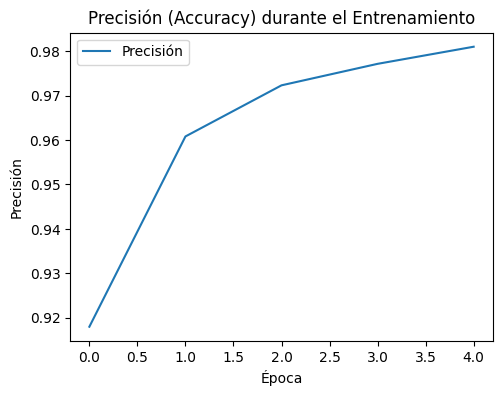

In [18]:
print("\nComenzando el entrenamiento del modelo (5 épocas)...")
# epochs=5: El modelo verá todo el set de entrenamiento 5 veces.
history = model.fit(
	train_dataset,
	epochs=5,
	steps_per_epoch=steps_per_epoch # El número de lotes por época.
)
print("\n¡Entrenamiento completado!")

# Opcional: Visualizar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión')
plt.title('Precisión (Accuracy) durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Este código es el que inicia el entrenamiento de tu modelo de red neuronal y, de forma opcional, visualiza los resultados del entrenamiento.

1.  **`model.fit(...)`**: Esta es la función clave para entrenar el modelo. Le pasamos los datos de entrenamiento (`train_dataset`), le indicamos que queremos que el modelo vea todo el conjunto de entrenamiento 5 veces (`epochs=5`), y le decimos cuántos lotes hay en cada época (`steps_per_epoch`). Durante este proceso, el modelo ajusta sus pesos y sesgos para minimizar la función de pérdida y mejorar la precisión.
2.  **Visualización (opcional)**: Después del entrenamiento, el código utiliza  `matplotlib`  para crear un gráfico de la precisión del modelo en cada época. Esto te permite ver cómo el modelo ha ido aprendiendo y mejorando su rendimiento a lo largo del tiempo.

## ✅ 5. Evaluación y Pruebas

### 5.1. Evaluar contra Datos Nunca Vistos

Usamos el `test_dataset` (10,000 imágenes) para obtener una medida objetiva de rendimiento.

In [22]:
print("\nEvaluando el modelo contra el dataset de prueba...")
test_loss, test_accuracy = model.evaluate(
	test_dataset, steps=math.ceil(num_test_examples/BATCHSIZE)
)

print("\n--- Resultado Final ---")
print(f"Precisión (Accuracy) en las pruebas: {test_accuracy*100:.2f}%")
print("-----------------------")


Evaluando el modelo contra el dataset de prueba...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9752 - loss: 0.0775

--- Resultado Final ---
Precisión (Accuracy) en las pruebas: 97.50%
-----------------------



Esta celda de código se encarga de  **evaluar el modelo de red neuronal**  que acabas de entrenar. La evaluación se realiza utilizando el  `test_dataset`, que contiene imágenes que el modelo  **nunca ha visto**  durante el entrenamiento. Esto es crucial para tener una medida objetiva y realista de qué tan bien generaliza el modelo a datos nuevos.

1.  **`print("\nEvaluando el modelo contra el dataset de prueba...")`**: Simplemente muestra un mensaje informativo en la consola, indicando que el proceso de evaluación ha comenzado.
2.  **`test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCHSIZE))`**:
    -   **`model.evaluate(...)`**: Esta es la función de Keras que toma el  `test_dataset`  (conjunto de datos de prueba) y lo pasa a través del modelo. Calcula la función de pérdida (`test_loss`) y las métricas (`test_accuracy`) definidas durante la compilación del modelo.
    -   **`steps=math.ceil(num_test_examples/BATCHSIZE)`**: Al igual que en el entrenamiento, aquí se especifica el número de lotes que el modelo debe procesar para completar una pasada por el  `test_dataset`. Se utiliza  `math.ceil`  para asegurarse de que todos los ejemplos se incluyan, incluso si el último lote es más pequeño.
    -   La función devuelve dos valores:  `test_loss`  (el valor de la función de pérdida en el conjunto de prueba) y  `test_accuracy`  (la precisión del modelo en el conjunto de prueba).
3.  **`print("\n--- Resultado Final ---")`**  y  **`print(f"Precisión (Accuracy) en las pruebas: {test_accuracy*100:.2f}%")`**:
    -   Estas líneas imprimen la precisión final del modelo en el conjunto de prueba, mostrándola como un porcentaje con dos decimales. Este es el indicador más importante para saber qué tan bien tu modelo se desempeñará en el mundo real, clasificando dígitos que nunca ha visto antes.

En resumen, este código te da el  **veredicto final**  sobre el rendimiento de tu red neuronal.


### 5.2. Funciones de Visualización (Didácticas)

Estas funciones nos ayudarán a visualizar las predicciones en detalle.

In [23]:
# Tomamos un lote de imágenes para probar y visualizar
for test_images, test_labels in test_dataset.take(1):
	test_images = test_images.numpy()
	test_labels = test_labels.numpy()
	predictions = model.predict(test_images)

# Función para mostrar la imagen y la predicción del modelo
def plot_image(i, predictions_array, true_labels, images):
	predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img[...,0], cmap=plt.cm.binary)

	predicted_label = np.argmax(predictions_array)

	# Azul = Correcto. Rojo = Incorrecto.
	if predicted_label == true_label:
		color = 'blue'
	else:
		color = 'red'

	plt.xlabel(f"Predicción: {class_names[predicted_label]} ({100*np.max(predictions_array):.2f}%)", color=color)

# Función para mostrar el gráfico de barras de probabilidades
def plot_value_array(i, predictions_array, true_label):
	predictions_array, true_label = predictions_array[i], true_label[i]
	plt.grid(False)
	plt.xticks(range(10), class_names, rotation=45) # Rotamos para que quepan
	plt.yticks([])
	thisplot = plt.bar(range(10), predictions_array, color="#888888")
	plt.ylim([0,1])
	predicted_label = np.argmax(predictions_array)

	# El color AZUL indica la etiqueta REAL (correcta).
	# El color ROJO indica la predicción del modelo.
	thisplot[predicted_label].set_color('red')
	thisplot[true_label].set_color('blue')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Este código prepara las funciones para visualizar las predicciones de tu modelo. Primero, extrae un lote de imágenes y etiquetas del conjunto de prueba. Luego, define dos funciones principales:

1.  **`plot_image(i, predictions_array, true_labels, images)`**: Esta función está diseñada para mostrar una imagen individual. Recibe el índice de la imagen (`i`), el arreglo de predicciones, las etiquetas verdaderas y las imágenes. Su objetivo es graficar la imagen y superponer su predicción, la confianza de esa predicción y colorear el texto de la predicción de azul si es correcta o de rojo si es incorrecta.
    
2.  **`plot_value_array(i, predictions_array, true_label)`**: Esta función genera un gráfico de barras que muestra las probabilidades que el modelo asigna a cada una de las 10 clases (dígitos 0-9) para una imagen específica. Resalta la barra de la predicción del modelo en rojo y la barra de la etiqueta verdadera en azul, permitiéndote ver visualmente qué tan cerca estuvo el modelo de la respuesta correcta o si se equivocó y por qué.

### 5.3. Visualización de Resultados Detallados

Ejecuta esta celda para ver las predicciones del modelo en una selección de imágenes:

-   **Gráfico de barras:** Muestra la **confianza (probabilidad)** que tiene el modelo para cada dígito.
    
-   **Barra Azul:** Es la respuesta **correcta**.
    
-   **Barra Roja:** Es la **predicción** del modelo.
    
-   **Texto Rojo en la imagen:** Significa que el modelo **falló**.

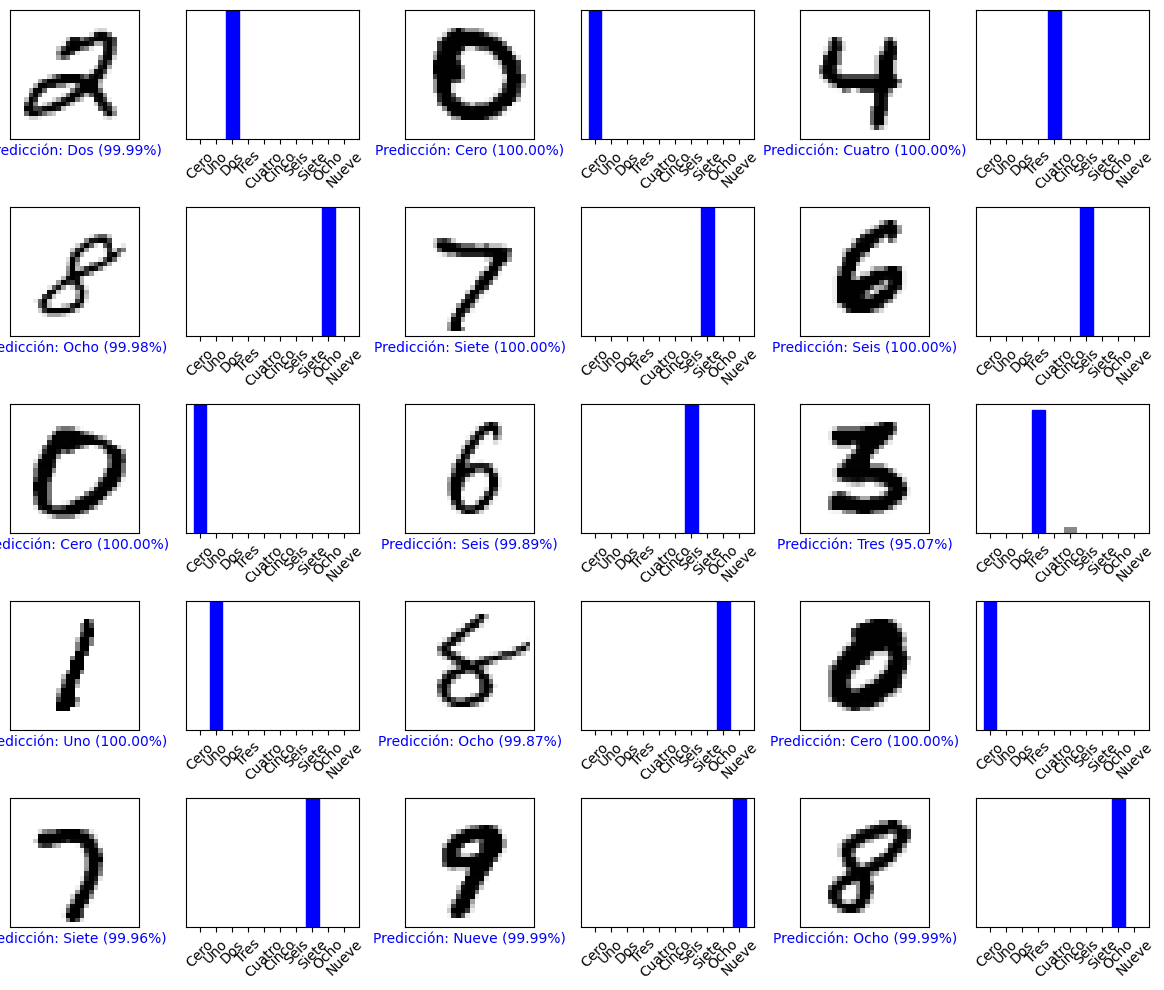

In [24]:
numrows=5
numcols=3
numimages = numrows*numcols

plt.figure(figsize=(2*2*numcols, 2*numrows))
for i in range(numimages):
	# Columna 1: La imagen y la predicción
	plt.subplot(numrows, 2*numcols, 2*i+1)
	plot_image(i, predictions, test_labels, test_images)

	# Columna 2: El gráfico de barras de probabilidades
	plt.subplot(numrows, 2*numcols, 2*i+2)
	plot_value_array(i, predictions, test_labels)

plt.tight_layout()
plt.show()

Este código genera una cuadrícula de visualizaciones para mostrar detalladamente cómo el modelo predice los dígitos en varias imágenes de prueba. Vamos a desglosarlo:

1.  **`numrows = 5`,  `numcols = 3`**: Estas líneas definen las dimensiones de la cuadrícula de visualizaciones que se va a crear. En este caso, serán 5 filas y 3 columnas.
2.  **`numimages = numrows * numcols`**: Calcula el número total de imágenes que se mostrarán en la cuadrícula, que es 15 (5 filas * 3 columnas).
3.  **`plt.figure(figsize=(2*2*numcols, 2*numrows))`**: Crea una nueva figura para  `matplotlib`  con un tamaño específico. El  `figsize`  se calcula para asegurar que cada imagen y su gráfico de barras tengan un espacio adecuado y sean legibles.
4.  **`for i in range(numimages):`**: Inicia un bucle que se ejecutará  `numimages`  (15) veces, una para cada imagen que se va a visualizar.
5.  **`plt.subplot(numrows, 2*numcols, 2*i+1)`**: Dentro del bucle, esta línea crea un subplot en la posición  `2*i+1`  dentro de una cuadrícula de  `numrows`  filas y  `2*numcols`  (6) columnas. La primera columna de cada par  `(2*i+1)`  se usará para la imagen.
6.  **`plot_image(i, predictions, test_labels, test_images)`**: Llama a la función previamente definida  `plot_image`  para dibujar la  `i`-ésima imagen, su predicción y el color correspondiente (azul para correcto, rojo para incorrecto) en el subplot actual.
7.  **`plt.subplot(numrows, 2*2*numcols, 2*i+2)`**: Esta línea crea el segundo subplot para la  `i`-ésima imagen, en la posición  `2*i+2`. Esta será la segunda columna de cada par  `(2*i+2)`  y se usará para el gráfico de barras.
8.  **`plot_value_array(i, predictions, test_labels)`**: Llama a la función  `plot_value_array`  para mostrar el gráfico de barras con las probabilidades de predicción para la  `i`-ésima imagen, resaltando la predicción del modelo y la etiqueta verdadera.
9.  **`plt.tight_layout()`**: Ajusta automáticamente los parámetros del subplot para darles un relleno ajustado, evitando superposiciones.
10.  **`plt.show()`**: Muestra todas las visualizaciones generadas por  `matplotlib`  en pantalla.

En resumen, este código itera a través de un lote de imágenes de prueba, y por cada imagen, muestra la imagen en sí con la predicción del modelo y un gráfico de barras que detalla la confianza del modelo en cada posible